# はじめに

このドキュメントでは、2015年度の長浜健康チャレンジにおけるグループ活動を分析する。

## データベースの作成

データは、manage.pyのサブコマンドである以下の２つのコマンドで収集されたデータを用いる

* loadmoves: 予め収集されたmovesのjsonデータをデータベースに格納する
* crawl_usergroup: Googleスプレッドシートからユーザ、グループ情報を抽出する

データベースは、analyzer.dbというsqlite3のファイルに格納される。詳しくは以下の２つのスクリプトを参照のこと

```
├── record
│   ├── management
│   │   └── commands
│   │       ├── crawl_usergroup.py
│   │       ├── loadmoves.py
```

## グループ人数ごとの統計

まず、グループの人数ごとに統計を出す。今回の実験では、5人、3人、1人の３種類のグループが設定されていたので、これらの人数の違いで、歩数や踏破距離に違いがあるのかを分析する。

In [1]:
import os
os.environ["DJANGO_SETTINGS_MODULE"] = "analyzer.settings"

import pandas
from analyzer import settings
from record.models import User, Group, Summary

import django

django.setup()
datasets = {}
for group in Group.objects.all():
    if group.session == "testseason": continue
    users = User.objects.filter(group=group)
    for user in users:
        for summary in Summary.objects.filter(username=user.username):
            if summary.steps == 0: continue
            user_count = users.count() if group.name != 'noteam' else 1
            datasets[(user_count, user.username, summary.date, summary.activity_type)] = (
                group.name,
                summary.steps,
                summary.distance,
                summary.duration
            )

data = pandas.DataFrame(datasets.values(), index=[datasets.keys(), ], columns=['group', 'steps', 'distance', 'duration'])
data.index.names = ['members', 'username', 'date', 'type']
data.transpose()  # 縦に並べると見にくいため

AppRegistryNotReady: Apps aren't loaded yet.

In [48]:
### 集計する

df_group5 = data.ix[5].groupby('group').mean()
df_group3 = data.ix[3].groupby('group').mean()
df_group1 = data.ix[1].groupby('group').mean()

(-0.5, 3)

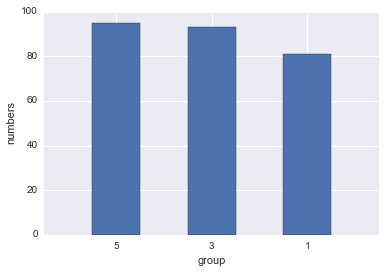

In [49]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

numbers = [df_group5.shape[0], df_group3.shape[0], df_group1.shape[0]]
plt.bar(numpy.arange(len(numbers)), numbers, 0.5)
plt.xticks(numpy.arange(len(numbers)) + 0.25, ('5', '3', '1'))
plt.xlabel('group')
plt.ylabel('numbers')
plt.xlim(-0.5, 3)

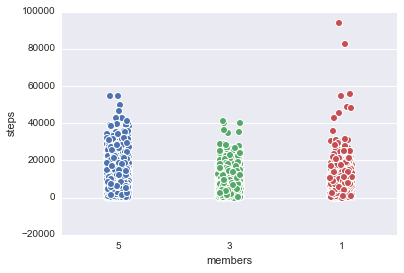

In [54]:
import seaborn as sns

datasets = []
for group in Group.objects.all():
    if group.session == "testseason": continue
    users = User.objects.filter(group=group)
    for user in users:
        for summary in Summary.objects.filter(username=user.username):
            if summary.steps == 0: continue
            user_count = users.count() if group.name != 'noteam' else 1
            datasets.append((
                user_count,
                user.username,
                summary.date,
                summary.activity_type,
                group.name,
                summary.steps,
                summary.distance,
                summary.duration
            ))

data = pandas.DataFrame(datasets, columns=['members', 'username', 'date', 'type', 'group', 'steps', 'distance', 'duration'])
data.transpose()

sns.stripplot(x="members", y="steps", data=data, jitter=True)

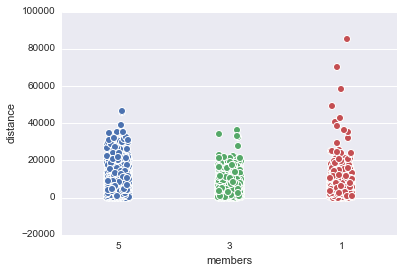

In [55]:
sns.stripplot(x="members", y="distance", data=data, jitter=True)

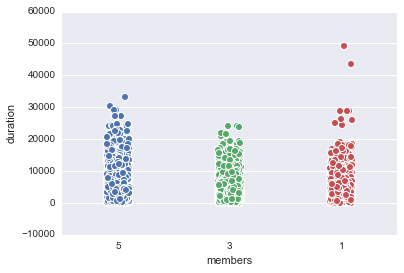

In [56]:
sns.stripplot(x="members", y="duration", data=data, jitter=True)